In [42]:
import matplotlib.pyplot as plt
import glob
from copy import copy
import pandas as pd
import numpy as np
import pyssam
import os 
import rotation

Read the data

In [2]:
path = os.getcwd()

#data_dir = "/data/visual/online/projects/LNdW-FaceStats/data/captured_faces_2024/"

data = []
for file in glob.glob(path + '/images/' + "*.txt"):
    data.append(pd.read_csv(file, sep=" ", header=None))
data=np.array(data)
data.shape

(159, 478, 2)

Create the shape model using the pyssam library

In [3]:
ssm = pyssam.SSM(data)

The Pyssam library deals with the standardization of the shapes and makes sure they are centered around the origin. However, it does not align the shapes. <br>Though gnerally the faces in our data look straight into the camera and are quite aligned, there are still slight differences in rotation, some of which are more visible.<br>
Below we can see an example of the difference in rotation between shapes.

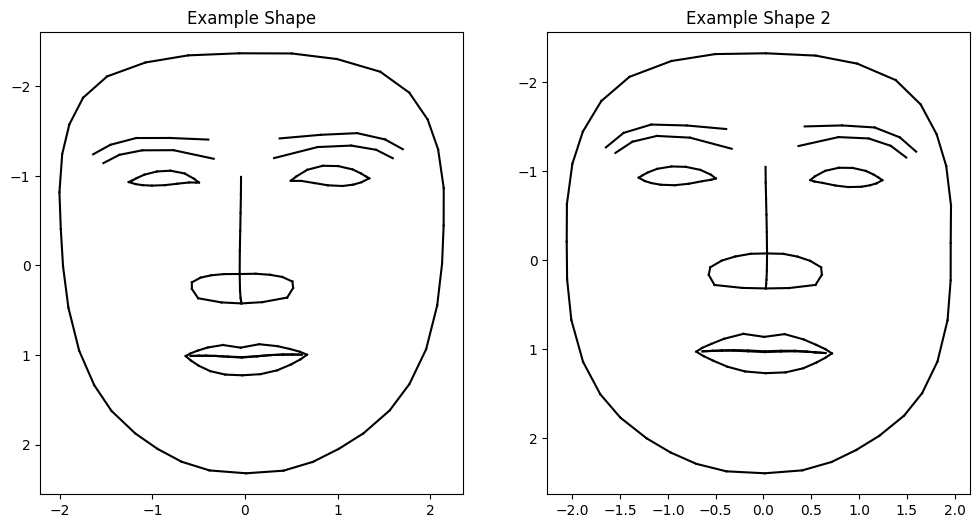

In [4]:
shape1 = ssm.landmarks_scale[3]
shape2 = ssm.landmarks_scale[4]

connections_contour = rotation.get_plotting_indexes()['full_contour']
rotation.plot_landmarks2(shape1, shape2, connections_contour, color = 'black', linewidth = 1.5,text1= "Example Shape", text2= "Example Shape 2")

In our case, we opt to align without scaling. Hence, we want to center all faces around the origin and deal with the rotation only. For that, we will use our auxillary module 'rotation', which rotates a shape to be aligned with the vertical axes.

In [5]:
# Rotate all faces in the dataset 
rotated_data = []
for face in data:
    rotated_face = rotation.rotate_shape(face)
    rotated_data.append(rotated_face)
rotated_data = np.array(rotated_data)

# Recreate the shape model with the rotated shapes.
ssm_rot = pyssam.SSM(rotated_data)
    

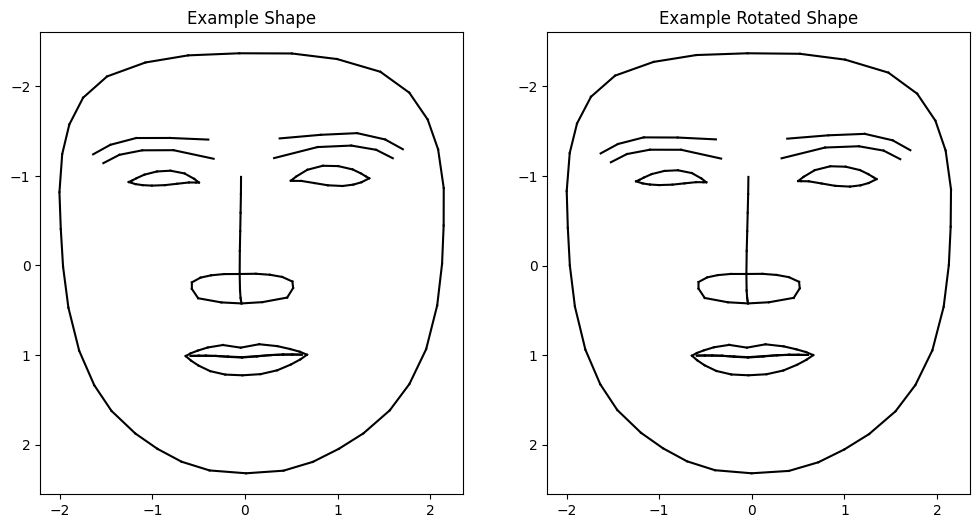

In [6]:
shape1 = ssm.landmarks_scale[3]
shape2 = ssm_rot.landmarks_scale[3]

connections_contour = rotation.get_plotting_indexes()['full_contour']
rotation.plot_landmarks2(shape1, shape2, connections_contour, color = 'black', linewidth = 1.5,text1= "Example Shape", text2= "Example Rotated Shape")

Now that we have a shape model with shapes centered and aligned around the origin, We can inspect the shape of the mean shape.

In [9]:
mean_shape_columnvector = ssm_rot.compute_dataset_mean()
mean_shape = mean_shape_columnvector.reshape(-1, 2)

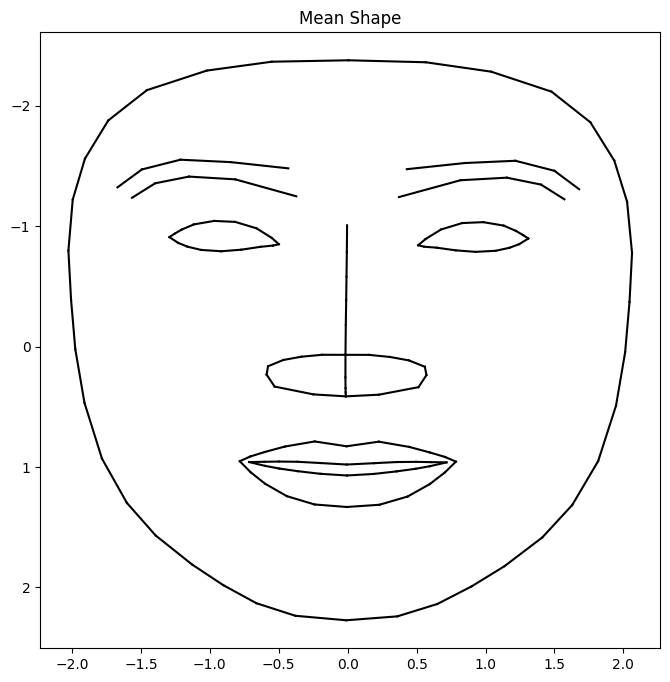

In [10]:
rotation.plot_landmarks(mean_shape, connections_contour, color = 'black', linewidth = 1.5,text1= "Mean Shape")

### PCA Analysis

In [11]:
ssm_rot.create_pca_model(ssm_rot.landmarks_columns_scale)
shape_model_componenets = ssm_rot.pca_model_components

To obtain 90.0% variance, 6 modes are required


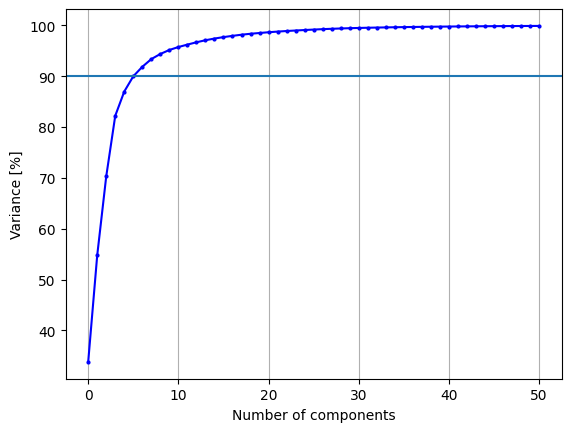

In [35]:
def plot_cumulative_variance(explained_variance, target_variance=0.9):
    top_threshold = np.where(np.cumsum(ssm_rot.pca_object.explained_variance_ratio_) > 0.999)[0][0]
    number_of_components = np.arange(0, top_threshold +1 )
    fig, ax = plt.subplots(1,1)
    color = "blue"
    ax.plot(number_of_components, explained_variance[0:top_threshold+1]*100.0, marker="o", ms=2, color=color, mec=color, mfc=color)
    if target_variance > 0.0:
        ax.axhline(target_variance*100.0)

    ax.set_ylabel("Variance [%]")
    ax.set_xlabel("Number of components")
    ax.grid(axis="x")
    plt.show()

print(f"To obtain {ssm_rot.desired_variance*100}% variance, {ssm_rot.required_mode_number} modes are required")
plot_cumulative_variance(np.cumsum(ssm_rot.pca_object.explained_variance_ratio_), 0.9)

Next we visualise the first 3 prinipal components, inspecting how they change the mean shape.

In [75]:
def plot_shape_modes(
  mean_shape_columnvector,
  mean_shape,
  original_shape_parameter_vector,
  shape_model_components,
  mode_to_plot,
):
  weights = [-3, 0, 3]
  fig, ax = plt.subplots(1, 3 , figsize=(15, 5))
  for j, weights_i in enumerate(weights):
    shape_parameter_vector = copy(original_shape_parameter_vector)
    shape_parameter_vector[mode_to_plot] = weights_i
    mode_i_coords = ssm_rot.morph_model(
        mean_shape_columnvector,
        shape_model_components,
        shape_parameter_vector
    ).reshape(-1, 2)

    offset_dist = pyssam.utils.euclidean_distance(
      mean_shape,
      mode_i_coords
    )
    # colour points blue if closer to point cloud centre than mean shape
    mean_shape_dist_from_centre = pyssam.utils.euclidean_distance(
      mean_shape,
      np.zeros(2),
    )
    mode_i_dist_from_centre = pyssam.utils.euclidean_distance(
      mode_i_coords,
      np.zeros(2),
    )
    offset_dist = np.where(
        mode_i_dist_from_centre<mean_shape_dist_from_centre,
        offset_dist*-1,
        offset_dist,
    )
    if weights_i == 0:
      ax[j].scatter(
        mode_i_coords[:, 0],
        mode_i_coords[:, 1],
        c="gray",
        s=3,
      )
      ax[j].set_title("mean shape")
    else:
      ax[j].scatter(
        mode_i_coords[:, 0],
        mode_i_coords[:, 1],
        c="gray",
        s=3,
      )
      ax[j].set_title(f"mode {mode_to_plot} \nweight {weights_i}")
    ax[j].axis('off')
    ax[j].invert_yaxis()
    ax[j].margins(0,0)
    ax[j].xaxis.set_major_locator(plt.NullLocator())
    ax[j].yaxis.set_major_locator(plt.NullLocator())

  plt.show()

explained variance is 33.79%


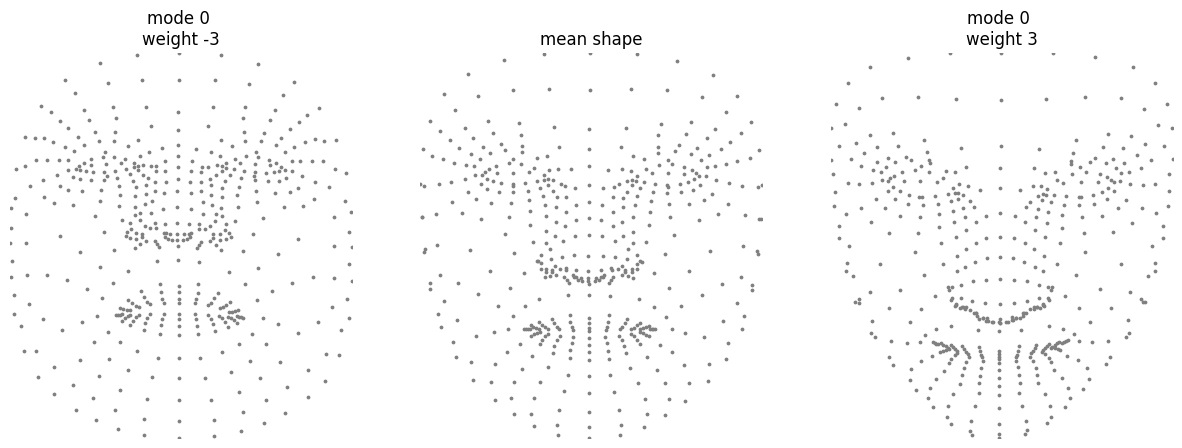

In [76]:
mode_to_plot = 0
print(f"explained variance is {np.round(ssm_rot.pca_object.explained_variance_ratio_[mode_to_plot]*100,2)}%")

plot_shape_modes(
    mean_shape_columnvector,
    mean_shape,
    ssm_rot.model_parameters,
    ssm_rot.pca_model_components,
    mode_to_plot,
)

explained variance is 20.98%


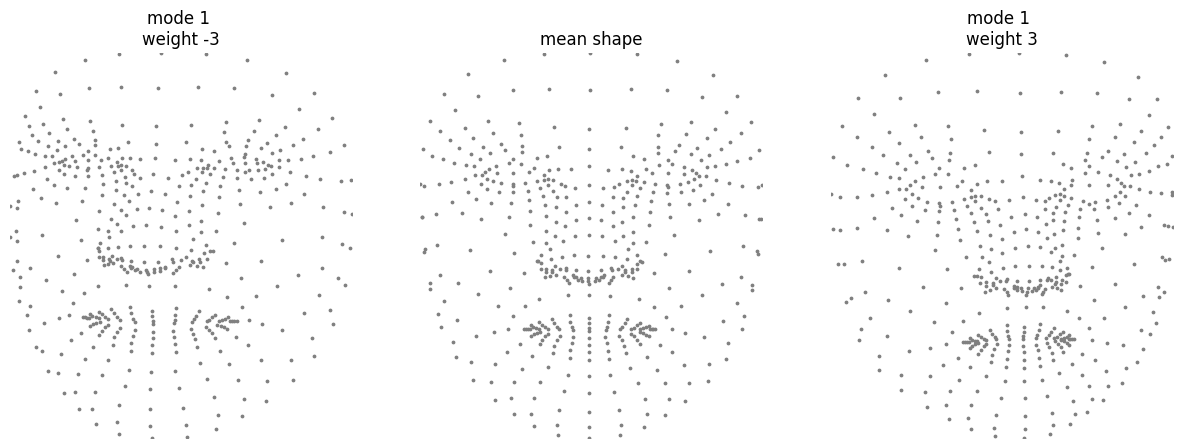

In [77]:
mode_to_plot = 1
print(f"explained variance is {np.round(ssm_rot.pca_object.explained_variance_ratio_[mode_to_plot]*100,2)}%")

plot_shape_modes(
    mean_shape_columnvector,
    mean_shape,
    ssm_rot.model_parameters,
    ssm_rot.pca_model_components,
    mode_to_plot,
)

explained variance is 15.54%


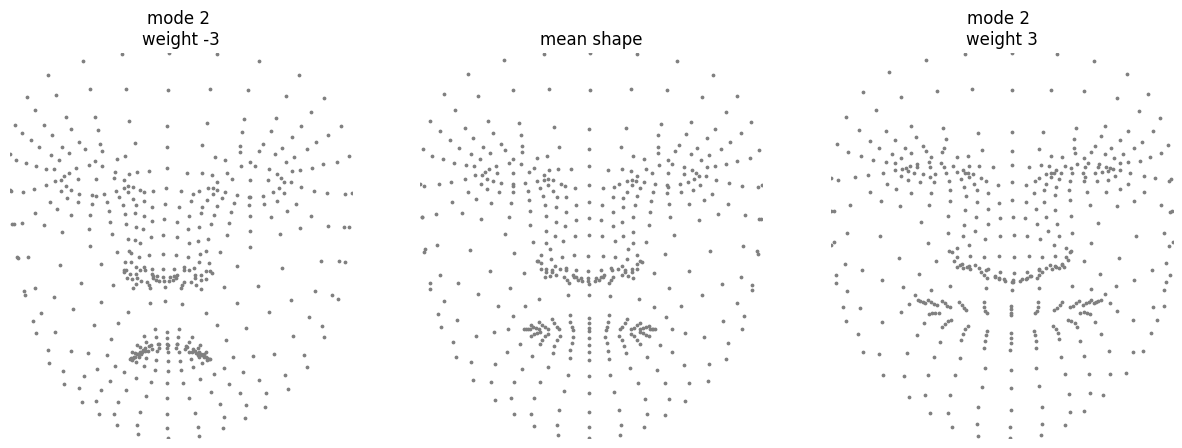

In [78]:
mode_to_plot = 2
print(f"explained variance is {np.round(ssm_rot.pca_object.explained_variance_ratio_[mode_to_plot]*100,2)}%")

plot_shape_modes(
    mean_shape_columnvector,
    mean_shape,
    ssm_rot.model_parameters,
    ssm_rot.pca_model_components,
    mode_to_plot,
)